# A three-layer multi-label-classification with custom NN class and tensorboard (GPU)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

## Setup tensorboard

In [9]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here.
# Note that this line alone creates a local 'runs/fashion_mnist_experiment_1' folder.
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

## Check if pytorch can use GPU

In [10]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
NVIDIA GeForce RTX 3080


## Set up training and testing dataset using MNIST

In [11]:
batch_size = 200
epochs = 10

# - First time it will download MNIST data online to `../data` path;
# - Parameter `transforms.Normalize((0.1307, ), (0.3081, ))` is some experiential normalization
#   parameters on original images which can improve the classification result. It can be skipped
#   if you don't need.
# - Distinguish training or testing dataset by setting `train=True` or `train=False`.
train_loader = torch.utils.data.DataLoader(datasets.MNIST(
    '../data',
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])),
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST(
    '../data',
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])),
                                          batch_size=batch_size,
                                          shuffle=True)

In [12]:
# Print a sample to verify the data loader.
# Each image in MNIST dataset is a 28x28 grayscale (1-channel) image.
# Then, data.shape should be [batch_size, 1, 28, 28], while target.shape should be [batch_size].
source, target = next(iter(train_loader))
print(source.shape, target.shape)
print(source.data, target.data)

torch.Size([200, 1, 28, 28]) torch.Size([200])
tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242

## Visualize some sample images on tensorboard

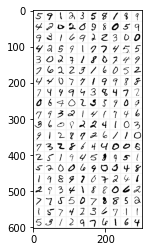

In [16]:
# Define a helper function to show images
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


# create grid of images
img_grid = torchvision.utils.make_grid(source, nrow=10)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('mnist_images_sample_first_batch', img_grid)

## Set up MLP layers
Here we use three layers and design a inherited class.

In [17]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(MLP, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(in_dim, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, out_dim),
            nn.ReLU(inplace=True),
        )
        # Initialize weights here
        self._init_weight('kaiming')

    # Initialization function, first checks the module type,
    # then applies the desired changes to the weights.
    def _init_weight(self, init_method):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if init_method == 'kaiming':
                    # 'fan_in': to create weight implicitly by creating a linear layer
                    nn.init.kaiming_normal_(m.weight, mode='fan_in')
                else:
                    nn.init.normal_(m.weight, 0, 0.01)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.model(x)
        return x


## Set up neural network

In [18]:
# Use the first GPU device
device = torch.device('cuda:0')

# NOTE: here 28*28 is input dimension, while 10 is output dimension (10 labels).
# Set '.to(device)' on neural network and loss to use GPU.
net = MLP(28 * 28, 10).to(device)
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
criteon = nn.CrossEntropyLoss().to(device)

## Inspect the model using TensorBoard

One of TensorBoard’s strengths is its ability to visualize complex model structures. Let’s visualize the model we built.

In [21]:
# Continue to use 'source' as example (first batch of images, size [batch_size, 1, 28, 28]).
# Note to convert it to [batch_size, 28*28] first to fit network input, and upload to GPU too.
source = source.view(-1, 28 * 28)
source = source.to(device)

writer.add_graph(net, source)
writer.close()

# Now upon refreshing TensorBoard you should see a “Graphs” tab. 

## Training and testing loop for epochs

In [ ]:


# Main loop
for epoch in range(epochs):

    # Training
    for batch_idx, (data, target) in enumerate(train_loader):
        # [b, 1, 28, 28] => [b, 28*28]
        data = data.view(-1, 28 * 28)

        # Send the data to GPU.
        data, target = data.to(device), target.to(device)

        # Call forward() function.
        logits = net(data)

        # NOTE: pytorch's CrossEntropyLoss() already contains softwax. So don't call it again.
        loss = criteon(logits, target)

        # Clear gradients to zero before computing them.
        optimizer.zero_grad()
        # Set up backward computation on loss
        loss.backward()
        # This will update newly computed gradients
        optimizer.step()

        # Print some loss values
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    # Testing
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data = data.view(-1, 28 * 28)
        data, target = data.to(device), target.to(device)

        logits = net(data)

        # .item() is to get value(s) from the loss
        test_loss += criteon(logits, target).item()

        # pred is to get all predicted labels. 'logits' should be [batch_size, 10], where 10 is number of labels.
        # - .max(1): get maximum values and indices along axis=1.
        # - .max(1)[1]: max(1) returns two items that, [0] is values of maximums, and [1] is indices of these maximum
        #               values (along the axis 1), while the latter is exactly the predicted labels.
        # pred = logits.max(1)[1]
        # NOTE: this works the same as above.
        pred = logits.argmax(dim=1)

        # Sum the number of correct prediction, by comparing predicted labels (pred) with target labels (target.data).
        # - .eq(): returns a tensor with same size of pred or target.data that, its value is 1 if the two corresponding
        #          values are equal, or 0 if not.
        # - .sum(): summarize all values to get the number of correct predictions.
        correct += pred.eq(target).sum()

    # Print testing loss for this epoch
    test_loss /= len(test_loader.dataset)
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
